# Algoritmo di Simon
Roberto Garbarino, Cristiano Olivari, Giacomo Garbarino, Greta Gandini

## Indice
1. [Problema di Simon](#what)  
2. [Algoritmo di Simon](#algo)  
3. [Creazione dell'oracolo](#oracle)  
4. [Codice](#code)
5. [Bibliografia](#bibb)

## Problema di Simon <a name='what'> </a>

L'algoritmo di Simon è stato il primo esempio di speed up esponenziale su un computer quantistico rispetto a un computer tradizionale.  
Data una funzione $f:\{0,1\}^n \rightarrow \{0,1\}^n$ con la proprietà che per qualche $s \in \{0,1\}^n$, per ogni $x, y \in \{0,1\}^n$, $f(x) = f(y)$ se e solo se $y = x \oplus s$.
Dobbiamo trovare s.

A livello classico per risolvere questo problema l'unica possibilità è quella di provare ogni $x$ e $y$ finchè non ne troviamo una coppia tale che $f(x) = f(y)$, con complessità quindi $O(\sqrt{2^n})$. Con un computer quantistico e l'algoritmo di Simon la complessità diventa $O(n)$.

##  Algoritmo di Simon <a name='algo'> </a>

1. Partiamo dallo stato $|\psi_0\rangle = |0\rangle^{\otimes n}|0\rangle^{\otimes n}$ e applichiamo $N$ porte di Hadamard ai primi n qubit con $N=2^n$:

$$
    |\psi_0\rangle \xrightarrow{H^{\otimes N}} |\psi_1\rangle = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} |x\rangle|0\rangle^{\otimes n}
$$
  
2. Ora applichiamo l'oracolo che per ogni $|x\rangle$ calcola $f(x)$ e immagazzina il valore nelle ancille.

$$
    |\psi_1\rangle \xrightarrow{O} |\psi_2\rangle = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} |x\rangle|f(x)\rangle
$$

3. Misuriamo le ancilla. Verrà osservato un certo valore di $f(x)$. Per come è stato impostato il problema $f(x)$ potrà corrispondere a $x$ o $x \oplus s$. Per cui il primo registro diventa
$$
    |\psi_3\rangle = \frac{1}{\sqrt{2}}  (|x\rangle + |x \oplus s\rangle)
$$

4. Applichiamo n porte di Hadamard
$$
        |\psi_4\rangle = \frac{1}{\sqrt{2N}} \sum_{y=0}^{N-1} (-1)^{xy} \big[1 + (-1)^{sy}\big] |y\rangle
$$

5. La misura dei rimanenti n qubit, darà una stringa $y$ tale che $sy = 0$. Supponiamo che questa sia $y_1$. La conoscenza di $y_1$ non ci permette di avere immediatamente $s$. Per questo dobbiamo iterare la procedura per ottenere diversi valori $y_2, y_3,..., y_n$ tali che $sy_i = 0$ per $i = 1,...,n$. Con questi $y_i$ possiamo risolvere il seguente sistema di equazioni:
$$
    \begin{cases} 
        s·y_1=0\\
        s·y_2=0\\
        ...\\
        s·y_n = 0\\
    \end{cases}
$$
da cui possiamo determinare s per esempio tramite eliminazione gaussiana.

Quindi, in questo particolare problema l'algoritmo quantistico esegue esponenzialmente meno step rispetto a quello classico. Non è semplice visionare tale algoritmo in un contesto reale, ma rappresenta la prima prova che ci può essere uno speed-up esponenziale nel risolvere uno specifico problema usando un computer quantistico.

## Creazione dell'Oracolo <a name='oracle'> </a>

Creiamo una funzione `oracle` per la stringa `s = 111` che agisce nel seguente modo:

1. Copia il contenuto dei primi registri nelle ancille. Questo passaggio è molto semplice in quanto dato che le ancille sono tutte $|0\rangle$ basterà applicare delle porte $CNOT$ sulle ancilla usando i primi registri come controllo.
```
    for i in range(n):
        circuit.cx(qubit[i], qubit[n+i])
```
con n la lunghezza della stringa.  
  
  
2. Applica delle porte $CNOT$ usando come qubit di controllo il primo.
```
    for i in range(n):
        circuit.cx(qubit[0], qubit[n+i])
```


Dalla seguente tabella si può vedere il funzionamento:


| x  | f(x)| x ⊕ s | f(x⊕s)| 
|:------:|:-------:|:--------------:|:----------------:|
| 000  |  000  |      111     |      000       |
| 001  |  001  |      110     |      001       |
| 010  |  010  |      101     |      010       |
| 011  |  011  |      100     |      011       |
| 100  |  011  |      011     |      011       |
| 101  |  010  |      010     |      010       |
| 110  |  001  |      001     |      001       |
| 111  |  000  |      000     |      000       |

In [1]:
#initialization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# importing Qiskit
from qiskit import BasicAer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.compiler import transpile
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [2]:
def oracle(hiddenString, circuit, qubit):
    n = len(hiddenString)
    #copy
    for i in range(n):
        circuit.cx(qubit[i], qubit[n+i])
    #cnot gates
    for i in range(n):
        circuit.cx(qubit[0], qubit[n+i]) 

## Codice <a name='code'> </a>

In [3]:
s = "111" # the hidden bitstring
n = len(s) #the length of the bitstring

Iniziamo creando il circuito e i relativi registri. Dopodichè applichiamo $n$ porte di Hadamard:

In [4]:
# Step 1
# Creating registers
qr = QuantumRegister(2*n)
cr = ClassicalRegister(2*n)
simonCircuit = QuantumCircuit(qr, cr)

# Step 2
# Apply Hadamard gates
for i in range(n):
    simonCircuit.h(qr[i])

Chiamiamo l'oracolo per trasformare il nostro stato in $|\psi\rangle = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} |x\rangle|f(x)\rangle$

In [5]:
# Step 3 query the oracle
simonCircuit.barrier()
oracle(s,simonCircuit,qr)
simonCircuit.barrier()

Adesso misuriamo le ancille e applichiamo le porte $H$ ai primi registri:

In [6]:
# Measure ancilla qubits
for i in range(n, 2*n):
    simonCircuit.measure(qr[i], cr[i])

simonCircuit.barrier()

# Step 4 apply Hadamard gates to the first register
for i in range(n):
    simonCircuit.h(qr[i])

simonCircuit.barrier()

Misuriamo i rimanenti registri per ottenere un valore di $y$:

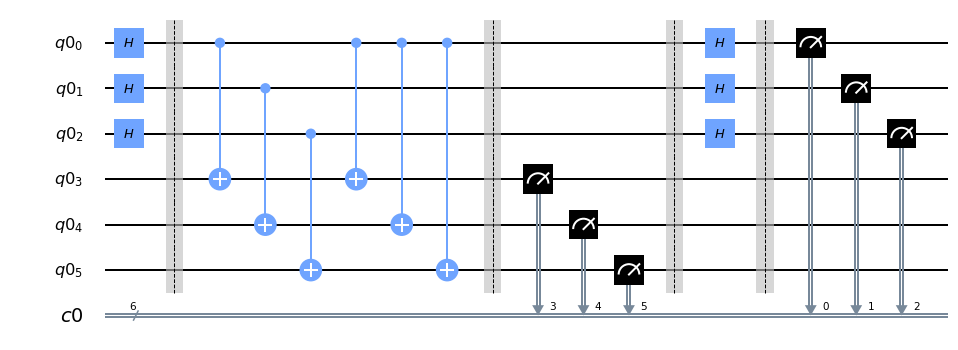

In [7]:
# Step 5 perform measurement on the first register
for i in range(n):
    simonCircuit.measure(qr[i], cr[i])

#draw the circuit
simonCircuit.draw(output='mpl')

Testiamo il nostro circuito su un simulatore (locale) con 1024 shots.
I dati hanno bisogno di un po' di manipolazione perchè si possano capire meglio. Dato che avremo delle misurazioni che tengono conto dei qubit ancilla, condenseremo quelle con i primi registri in comune. Per esempio le misurazioni 000000, 010000, 100000, 110000 verranno tutte condensate in 000.


{'110': 235, '011': 251, '000': 270, '101': 268}


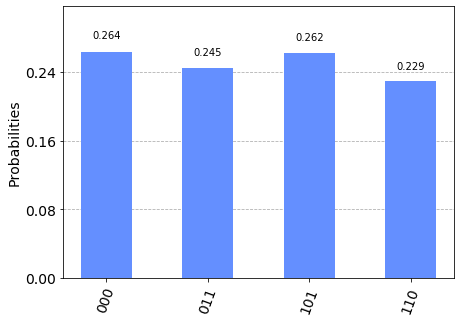

In [8]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(simonCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
# Categorize measurements by input register values
answer_plot = {}
for measresult in answer.keys():
    measresult_input = measresult[len(str(s)):]
    if measresult_input in answer_plot:
        answer_plot[measresult_input] += answer[measresult]
    else:
        answer_plot[measresult_input] = answer[measresult] 

# Plot the categorized results
print( answer_plot )
plot_histogram(answer_plot)

Per trovare s adesso basta risolvere il seguente sistema lineare:

In [29]:
for elem in answer_plot:
    print ("s·" + elem + " = 0")

s·110 = 0
s·011 = 0
s·000 = 0
s·101 = 0


## Bibliografia <a name='bibb'> </a>

[1] Daniel R. Simon (1997) "On the Power of Quantum Computation" SIAM Journal on Computing, 26(5)  
[2] Dispense del corso di Computazione Quantistica a cura di Paolo Solinas
